# Bayesian Statistics Made Simple

Code and exercises from my workshop on Bayesian statistics in Python.

Copyright 2020 Allen Downey

MIT License: https://opensource.org/licenses/MIT

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## The Euro problem

Here's a problem from David MacKay's book, [*Information Theory, Inference, and Learning Algorithms*](http://www.inference.org.uk/mackay/itila/p0.html), which is the book where I first learned about Bayesian statistics.  MacKay writes:

> A statistical statement appeared in The Guardian on
Friday January 4, 2002:
>
> >"When spun on edge 250 times, a Belgian one-euro coin came
up heads 140 times and tails 110. ‘It looks very suspicious
to me’, said Barry Blight, a statistics lecturer at the London
School of Economics. ‘If the coin were unbiased the chance of
getting a result as extreme as that would be less than 7%’."
>
> But [asks MacKay] do these data give evidence that the coin is biased rather than fair?

To answer this question, we have to make some modeling choices.

First, let's assume that if you spin a coin on edge, there is some probability that it will land heads up.  I'll call that probability $x$.

Second, let's assume that $x$ varies from one coin to the next, depending on how the coin is balanced and maybe some other factors.

With these assumptions we can formulate MacKay's question as an inference problem: given the data --- 140 heads and 110 tails --- what do we think $x$ is for this coin?

This formulation is similar to the 101 Bowls problem we saw in the previous notebook.

But in the 101 Bowls problem, we are told that we choose a bowl at random, which implies that all bowls have the same prior probability.

For the Euro problem, we have to think harder about the prior.  What values of $x$ do you think are reasonable?

It seems likely that many coins are "fair", meaning that the probability of heads is close to 50%.  Do you think there are coins where $x$ is 75%?  How about 90%?

To be honest, I don't really know.  To get started, I will assume that all values of $x$, from 0% to 100%, are equally likely.  Then we'll come back and try another prior.

Here's a uniform prior from 0 to 100.

In [2]:
xs = np.linspace(0, 1, num=101)
p = 1/101
prior = pd.Series(p, index=xs)

And here's what it looks like.

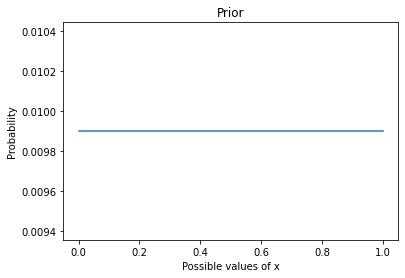

In [3]:
prior.plot()

plt.xlabel('Possible values of x')
plt.ylabel('Probability')
plt.title('Prior');

Here are the likelihoods for heads and tails:

In [4]:
likelihood_heads = xs
likelihood_tails = 1 - xs

Suppose we toss the coin twice and get one heads and one tails.

We can compute the posterior probability for each value of $x$ like this:

In [5]:
posterior = prior * likelihood_heads * likelihood_tails
posterior /= posterior.sum()

And here's what the posterior distribution looks like.

0.5

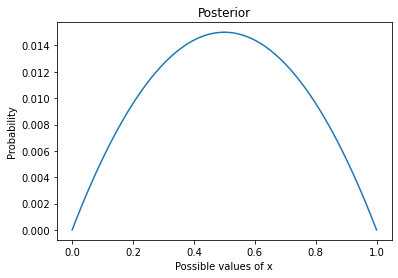

In [6]:
posterior.plot()

plt.xlabel('Possible values of x')
plt.ylabel('Probability')
plt.title('Posterior')

posterior.idxmax()

### Exercise 1

Go back and run the update again for the following outcomes:

* Two heads, one tails.

* 7 heads, 3 tails.

* 70 heads, 30 tails.

* 140 heads, 110 tails.

## A better prior

Remember that this result is based on a uniform prior, which assumes that any value of $x$ from 0 to 100 is equally likely.

Given what we know about coins, that's probably not true.  I can believe that if you spin a lop-sided coin on edge, it might be somewhat more likely to land on heads or tails.  

But unless the coin is heavily weighted on one side, I would be surprised if $x$ were greater than 60% or less than 40%.

Of course, I could be wrong, but in general I would expect to find $x$ closer to 50%, and I would be surprised to find it near 0% or 100%.

We can represent that prior belief with a triangle-shaped prior.
Here's an array that ramps up from 0 to 49 and ramps down from 50 to 0.

In [7]:
ramp_up = np.arange(50)
ramp_down = np.arange(50, -1, -1)

ps = np.append(ramp_up, ramp_down)

I'll put it in a `Series` and normalize it so it adds up to 1.

In [8]:
triangle = pd.Series(ps, xs)
triangle /= triangle.sum()

Here's what the triangle prior looks like.

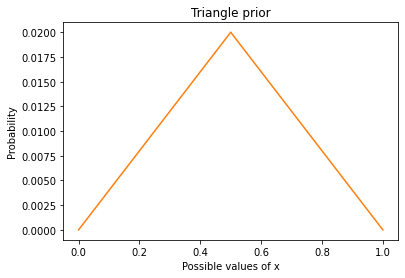

In [9]:
triangle.plot(color='C1')

plt.xlabel('Possible values of x')
plt.ylabel('Probability')
plt.title('Triangle prior');

Now let's update it with the data.

In [10]:
posterior1 = prior * likelihood_heads**140 * likelihood_tails**110
posterior1 /= posterior1.sum()

In [11]:
posterior2 = triangle * likelihood_heads**140 * likelihood_tails**110
posterior2 /= posterior2.sum()

And plot the results, along with the posterior based on a uniform prior.

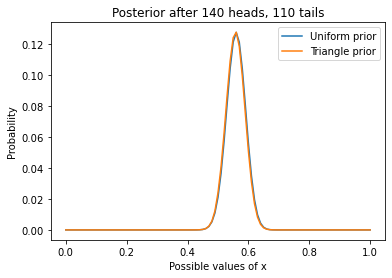

In [12]:
posterior1.plot(label='Uniform prior')
posterior2.plot(label='Triangle prior')

plt.xlabel('Possible values of x')
plt.ylabel('Probability')
plt.title('Posterior after 140 heads, 110 tails')
plt.legend();

The posterior distributions are almost identical because, in this case, we have enough data to "swamp the prior"; that is, the posteriors depend strongly on the data and only weakly on the priors.

This is good news, because it suggests that we can use data to resolve arguments.  Suppose two people disagree about the correct prior.  If neither can persuade the other, they might have to agree to disagree.

But if they get new data, and each of them does a Bayesian update, they will usually find their beliefs converging.

And with enough data, the remaining difference can be so small that it makes no difference in practice.

## Summarizing the posterior distribution

The posterior distribution contains all of the information we have about the value of $x$.  But sometimes we want to summarize this information.

We have already seen one way to summarize a posterior distribution, the Maximum Aposteori Probability, or MAP:

In [13]:
posterior1.idxmax()

0.56

`idxmax` returns the value of $x$ with the highest probability.

In this example, we get the same MAP with the triangle prior:

In [14]:
posterior2.idxmax()

0.56

Another way to summarize the posterior distribution is the posterior mean.

Given a set of values, $x_i$, and the corresponding probabilities, $p_i$, the mean of the distribution is:

$\sum_i x_i p_i$

The following function takes a Pmf and computes its mean.  Note that this function only works correctly if the Pmf is normalized.

In [15]:
def pmf_mean(pmf):
    """Compute the mean of a PMF.
    
    pmf: Series representing a PMF
    
    return: float
    """
    return np.sum(pmf.index * pmf)

Here's the posterior mean based on the uniform prior:

In [16]:
pmf_mean(posterior1)

0.5595238095238096

And here's the posterior mean with the triangle prior:

In [17]:
pmf_mean(posterior2)

0.5574349943859507

The posterior means are not identical, but they are close enough that the difference probably doesn't matter.

In this example, the posterior mean is very close to the MAP.  That's true when the posterior distribution is symmetric, but it is not always true.

If someone asks what we think $x$ is, the MAP or the posterior mean might be a good answer.

## Credible intervals

Another way to summarize a posterior distribution is a credible interval, which is a range of quantities whose probabilities add up to a given total.

The following function takes a `Series` as a parameter and a probability, `prob`, and return an interval that contains the given probability.

If you are interested, it computes the cumulative distribution function (CDF) and then uses interpolation to estimate percentiles.

In [18]:
from scipy.interpolate import interp1d

def credible_interval(pmf, prob):
    """Compute the mean of a PMF.
    
    pmf: Series representing a PMF
    prob: probability of the interval
    
    return: pair of float
    """
    # make the CDF
    xs = pmf.index
    ys = pmf.cumsum()
    
    # compute the probabilities
    p = (1-prob)/2
    ps = [p, 1-p]
    
    # interpolate the inverse CDF
    options = dict(bounds_error=False,
                   fill_value=(xs[0], xs[-1]), 
                   assume_sorted=True)
    interp = interp1d(ys, xs, **options)
    return interp(ps)

Here's the 90% credible interval for `posterior1`.

In [19]:
credible_interval(posterior1, 0.9)

array([0.50259405, 0.60603433])

And for `posterior2`.

In [20]:
credible_interval(posterior2, 0.9)

array([0.50114608, 0.60373672])

The credible interval for `posterior2` is slightly narrower.